### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
ls /mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_1/nih_us_cvd/v2_myocardial_infarction/2022_08_08_16_57_10

__pycache__/   count_data/    model_specification.yaml  settings.py
alabama.hdf    keyspace.yaml  output.hdf
branches.yaml  logs/          requirements.txt


In [3]:
ls /mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_1/nih_us_cvd/v2_myocardial_infarction/2022_08_08_16_57_10/count_data

deaths.csv      population.hdf         transition_count.csv  ylds.hdf
deaths.hdf      state_person_time.csv  transition_count.hdf  ylls.csv
population.csv  state_person_time.hdf  ylds.csv              ylls.hdf


In [4]:
sim_results_dir = '/mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_1/nih_us_cvd/v2_myocardial_infarction/2022_08_08_16_57_10/count_data/'

### Exploring Data

In [5]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0


In [6]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,baseline,750000
1,1,total_population,232,baseline,750000
2,2,total_population,357,baseline,750000
3,3,total_population,394,baseline,750000
4,4,total_population,602,baseline,750000


In [7]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [8]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])] 
person_time.value.sum()

102901206.08898014

In [9]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])] 
person_time_test.value.sum()

102901206.08898014

### Total DALYs by Year

In [10]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
daly = pd.concat([yll, yld.yld], axis=1)
daly['daly'] = daly['yll'] + daly['yld'] 

daly.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,yll,yld,daly
0,0,female,2023,acute_ischemic_stroke,ylls,29,baseline,25_to_29,0.0,0.000231,0.000231
1,1,female,2023,acute_ischemic_stroke,ylls,29,baseline,30_to_34,0.0,0.000175,0.000175
2,2,female,2023,acute_ischemic_stroke,ylls,29,baseline,35_to_39,0.0,0.000417,0.000417
3,3,female,2023,acute_ischemic_stroke,ylls,29,baseline,40_to_44,0.0,0.000673,0.000673
4,4,female,2023,acute_ischemic_stroke,ylls,29,baseline,45_to_49,0.0,0.001373,0.001373


In [11]:
daly_sum = (daly
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,1254.617186,0.000293,9030.153355
1,2024,1188.777275,0.000323,8506.106446
2,2025,1202.035513,0.000240,8547.440390
3,2026,779.417367,0.000183,7184.530186
4,2027,1102.237351,0.000489,7927.152602


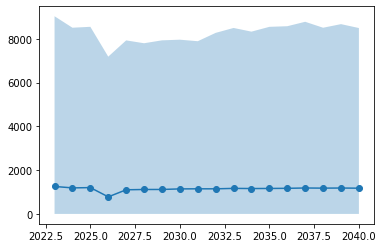

In [12]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [13]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,6.76,0.0,34.000
1,25_to_29,female,2024,5.72,0.0,26.550
2,25_to_29,female,2025,5.86,0.0,28.775
3,25_to_29,female,2026,5.30,0.0,30.100
4,25_to_29,female,2027,6.16,0.0,29.775


In [14]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('model1vv_v2_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [15]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,29970.157426
1,25_to_29,female,2023,232,30069.355236
2,25_to_29,female,2023,357,30065.215606
3,25_to_29,female,2023,394,30342.187543
4,25_to_29,female,2023,602,30300.944559


In [16]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001120,0.000925,0.001328
1,25_to_29,female,2024,0.001028,0.000674,0.001273
2,25_to_29,female,2025,0.001063,0.000819,0.001239
3,25_to_29,female,2026,0.000973,0.000536,0.001319
4,25_to_29,female,2027,0.001144,0.000722,0.001423


In [17]:
%%capture 
with PdfPages('model1vv_v2_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [18]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('model1vv_v2_acmr_by_year.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [19]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
1,5,25_to_29,female,2024,acute_ischemic_stroke,0.2,0.0,1.000
2,10,25_to_29,female,2025,acute_ischemic_stroke,0.0,0.0,0.000
3,15,25_to_29,female,2026,acute_ischemic_stroke,0.1,0.0,0.775
4,20,25_to_29,female,2027,acute_ischemic_stroke,0.1,0.0,0.775


In [20]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,0
1,5,25_to_29,female,2023,232,acute_ischemic_stroke,0
2,10,25_to_29,female,2023,357,acute_ischemic_stroke,0
3,15,25_to_29,female,2023,394,acute_ischemic_stroke,0
4,20,25_to_29,female,2023,602,acute_ischemic_stroke,0


In [21]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000003,0.0,0.000026
1,25_to_29,female,2024,0.000007,0.0,0.000036
2,25_to_29,female,2025,0.000000,0.0,0.000000
3,25_to_29,female,2026,0.000004,0.0,0.000029
4,25_to_29,female,2027,0.000004,0.0,0.000029


In [22]:
%%capture 
with PdfPages('model1vv_v2_acute_csmr.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [23]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.000000,0.000000
1,25_to_29,female,2024,0.000000,0.000000,0.000000
2,25_to_29,female,2025,0.000000,0.000000,0.000000
3,25_to_29,female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,male,2037,0.008232,0.002657,0.013745
537,95_plus,male,2038,0.009122,0.005100,0.015250
538,95_plus,male,2039,0.009800,0.006358,0.012246
539,95_plus,male,2040,0.008787,0.003974,0.016879


In [24]:
%%capture
with PdfPages('model1vv_v2_chronic_csmr.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction

In [25]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [26]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000109,0.000033,0.000243
1,25_to_29,female,2024,0.000140,0.000072,0.000244
2,25_to_29,female,2025,0.000080,0.000008,0.000145
3,25_to_29,female,2026,0.000055,0.000008,0.000110
4,25_to_29,female,2027,0.000104,0.000037,0.000251


In [27]:
%%capture
with PdfPages('model1vv_v2_acute_MI_csmr.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [28]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000043,0.000000,0.000100
1,25_to_29,female,2024,0.000061,0.000000,0.000164
2,25_to_29,female,2025,0.000076,0.000008,0.000229
3,25_to_29,female,2026,0.000048,0.000000,0.000110
4,25_to_29,female,2027,0.000078,0.000037,0.000148


In [29]:
%%capture
with PdfPages('model1vv_v2_post_MI_csmr.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [30]:
%%capture
with PdfPages('model1vv_v2_post_MI_csmr_byyear.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Ischemic Stroke

In [31]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.034677,0.000000,0.075749
1,25_to_29,female,2024,0.042662,0.000000,0.105858
2,25_to_29,female,2025,0.051047,0.005078,0.149956
3,25_to_29,female,2026,0.032025,0.000000,0.076568
4,25_to_29,female,2027,0.053212,0.023415,0.097087


In [32]:
%%capture
with PdfPages('model1vv_v2_post_MI_emr.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [33]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000009,2.531746e-06,0.000021
1,25_to_29,female,2024,0.000013,2.738028e-06,0.000029
2,25_to_29,female,2025,0.000009,6.175330e-07,0.000018
3,25_to_29,female,2026,0.000010,2.787893e-06,0.000019
4,25_to_29,female,2027,0.000008,0.000000e+00,0.000027


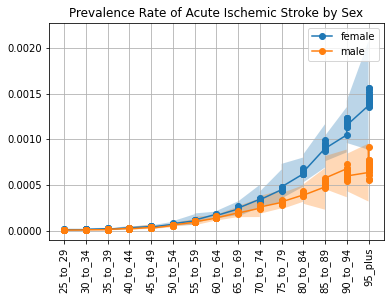

In [34]:
groups = prev_acute_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [35]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

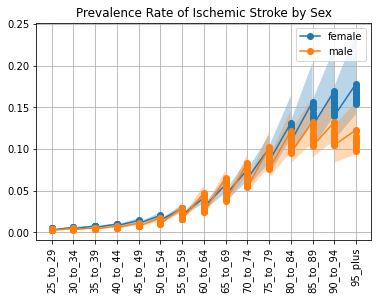

In [36]:
groups = prev_chronic_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

#### Myocardial Infarction

In [37]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000038,0.000021,0.000052
1,25_to_29,female,2024,0.000037,0.000027,0.000051
2,25_to_29,female,2025,0.000035,0.000020,0.000050
3,25_to_29,female,2026,0.000032,0.000010,0.000055
4,25_to_29,female,2027,0.000032,0.000015,0.000054


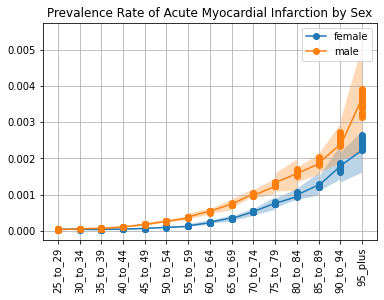

In [38]:
groups = prev_acute_MI_summ.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Myocardial Infarction by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [39]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001351,0.000926,0.001713
1,25_to_29,female,2024,0.001464,0.001185,0.001676
2,25_to_29,female,2025,0.001491,0.001276,0.001663
3,25_to_29,female,2026,0.001517,0.001253,0.001880
4,25_to_29,female,2027,0.001463,0.001201,0.001750


In [40]:
%%capture
for sex in prev_post_MI_summ.sex.unique():
    for year in prev_post_MI_summ.year.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.05)
        plt.grid()

### Incidence of First Time Acute Ischemic Stroke

In [41]:
tran.transition.unique()

array(['ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [42]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,2,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,3.4,1.000,8.325
1,8,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,5.0,1.000,9.550
2,14,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,3.0,0.225,6.775
3,20,25_to_29,female,2026,ischemic_stroke_susceptible_to_ischemic_stroke...,3.3,1.000,6.775
4,26,25_to_29,female,2027,ischemic_stroke_susceptible_to_ischemic_stroke...,3.1,0.000,10.325


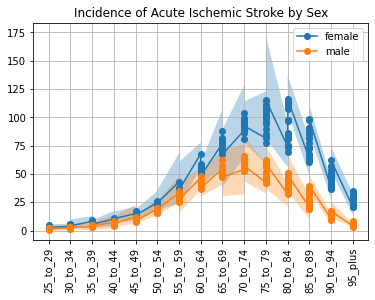

In [43]:
groups = tran_sum_stroke.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Incidence of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [44]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,20,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,29809.325120
1,21,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,29917.875428
2,22,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,29908.982888
3,23,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,394,30172.232717
4,24,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,602,30129.149897


In [45]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000258,0.0,0.000561
1,25_to_29,female,2025,0.000075,0.0,0.000231
2,25_to_29,female,2026,0.000244,0.0,0.000631
3,25_to_29,female,2028,0.000042,0.0,0.000173
4,25_to_29,female,2029,0.000250,0.0,0.000760


In [46]:
%%capture
with PdfPages('model1vv_v2_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [47]:
per_time_sus_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_susceptible_to_myocardial_infarction')].reset_index()
per_time_sus_MI.head()

,index,age,sex,year,state,input_draw,ptvalue
0,50,25_to_29,female,2023,myocardial_infarction_susceptible_to_myocardia...,29,29929.911020
1,51,25_to_29,female,2023,myocardial_infarction_susceptible_to_myocardia...,232,30025.199179
2,52,25_to_29,female,2023,myocardial_infarction_susceptible_to_myocardia...,357,30023.665982
3,53,25_to_29,female,2023,myocardial_infarction_susceptible_to_myocardia...,394,30288.142368
4,54,25_to_29,female,2023,myocardial_infarction_susceptible_to_myocardia...,602,30263.917864


In [48]:
tran_rate_MI = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate_MI = tran_rate_MI.loc[(tran_rate_MI['transition'] == 'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction')].reset_index()
tran_rate_MI = pd.concat([tran_rate_MI, per_time_sus_MI.ptvalue], axis=1)
tran_rate_MI['rate']= tran_rate_MI['value'] / tran_rate_MI['ptvalue']
tran_rate_MI_summ = (tran_rate_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000514,0.000364,0.000700
1,25_to_29,female,2024,0.000504,0.000295,0.000733
2,25_to_29,female,2025,0.000440,0.000256,0.000656
3,25_to_29,female,2026,0.000437,0.000137,0.000750
4,25_to_29,female,2027,0.000413,0.000194,0.000711


In [49]:
%%capture
with PdfPages('model1vv_v2_acute_MI_inc.pdf') as pdf:
    for sex in tran_rate_MI_summ.sex.unique():
        for year in tran_rate_MI_summ.year.unique():
            plt.figure() 
            subdata = tran_rate_MI_summ.loc[(tran_rate_MI_summ.sex==sex) & (tran_rate_MI_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Artifacts

In [50]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  washington.hdf


In [51]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/results/vivarium_nih_us_cvd/model_1/nih_us_cvd/v2_myocardial_infarction/2022_08_08_16_57_10/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [52]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [53]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.acute_myocardial_infarction.incidence_rate',
 'cause.post_myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarct

In [54]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [55]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [56]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [57]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001109,0.000595,0.001609
1,25_to_29,male,0.002321,0.001639,0.003117
2,30_to_34,female,0.001483,0.000968,0.002042
3,30_to_34,male,0.002595,0.001944,0.003323
4,35_to_39,female,0.001758,0.001246,0.002416


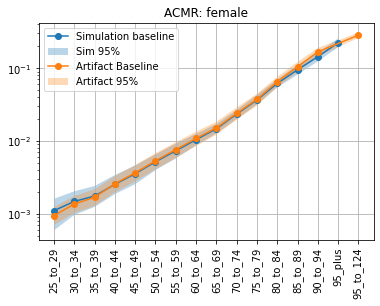

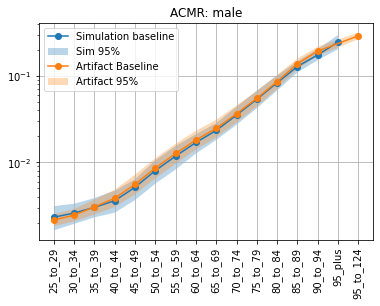

In [58]:
with PdfPages('model1vv_v2_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [59]:
def make_sim_vs_artifact_plots_by_age(sex, year, sim_data, art_data, measure):
    plt.figure(dpi=120) # this dpi makes the figure a little bigger and more clear
    plt.plot(sim_data.loc[(sim_data.sex==sex) & (sim_data.year==year)].age,
            sim_data.loc[(sim_data.sex==sex) & (sim_data.year==year)]['mean'], marker='o')
    plt.plot(art_data.loc[(art_data.sex==sex)].age_group,
            art_data.loc[(art_data.sex==sex)]['mean'], marker='o')
    plt.legend(['Simulation baseline', 'Artifact']) # legend so we know which color is which
    plt.xticks(rotation=90)
    plt.title(f'{measure}: {sex} {year}') # title for ease of review
    plt.grid()
    plt.semilogy()

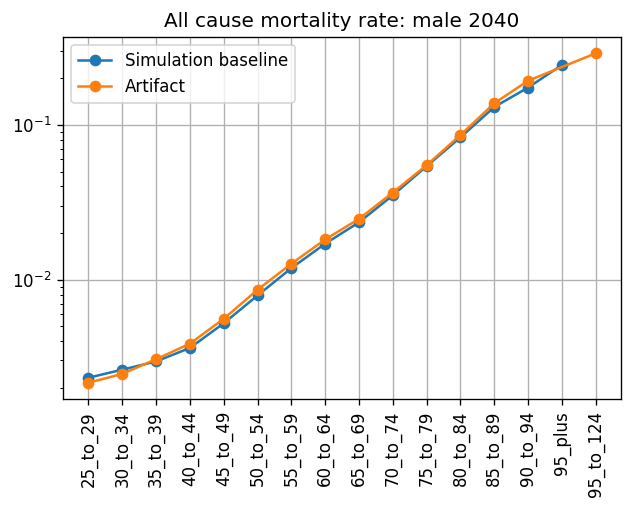

In [60]:
make_sim_vs_artifact_plots_by_age('male', 2040, result_summary, art_acmr, 'All cause mortality rate')

### Cause Specific Mortality Rates

#### Stroke

In [61]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [62]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [63]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [64]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [65]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000002,0.0,0.000038
1,25_to_29,male,0.000004,0.0,0.000039
2,30_to_34,female,0.000003,0.0,0.000037
3,30_to_34,male,0.000005,0.0,0.000037
4,35_to_39,female,0.000008,0.0,0.000057


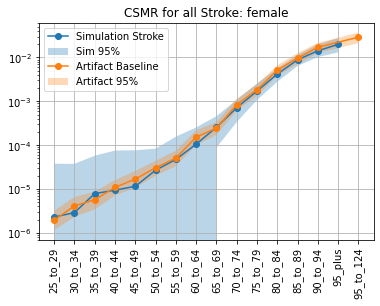

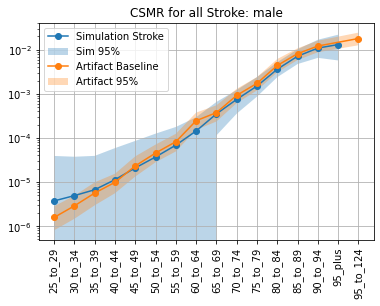

In [66]:
with PdfPages('model1vv_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Myocardial Infarction

In [67]:
art_csmr2 = load_artifact_data('cause', 'myocardial_infarction', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000017,0.000012,0.000024,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000047,0.000034,0.000064,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000098,0.000072,0.000132,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000232,0.000165,0.000311,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000393,0.000291,0.000513,Alabama,cause_specific_mortality_rate,45_to_49


In [68]:
acute_MI_rate_allyear = (acute_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [69]:
post_MI_rate_allyear = (post_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

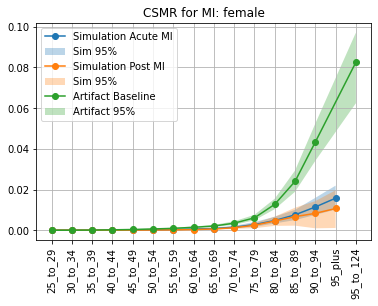

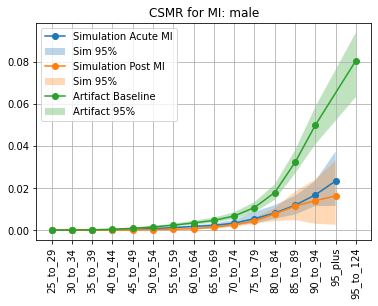

In [70]:
with PdfPages('model1vv_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_MI_rate_allyear.sex.unique():
        plt.figure() 
        subdata = acute_MI_rate_allyear.loc[(acute_MI_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = post_MI_rate_allyear.loc[(post_MI_rate_allyear.sex==sex)]
        plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Acute MI', 'Sim 95%', 'Simulation Post MI', 'Sim 95%','Artifact Baseline', 'Artifact 95%']) 

In [71]:
acute_MI_rate = acute_MI_rate.rename(columns = {'mean_rate':'acute_rate'})
post_MI_rate = post_MI_rate.rename(columns = {'mean_rate':'post_rate'})
total_MI_rate = pd.concat([acute_MI_rate, post_MI_rate.post_rate], axis=1)
total_MI_rate['total_rate'] = total_MI_rate['acute_rate'] + total_MI_rate['post_rate']
total_MI_rate_allyear = (total_MI_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000163,0.000017,0.000342
1,25_to_29,male,0.000183,0.000038,0.000385
2,30_to_34,female,0.000156,0.000036,0.000341
3,30_to_34,male,0.000207,0.000054,0.000390
4,35_to_39,female,0.000130,0.000000,0.000298


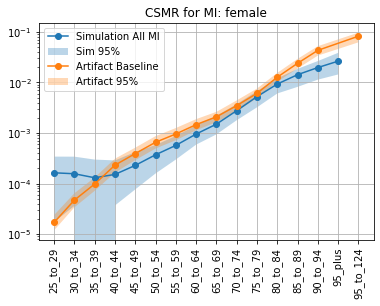

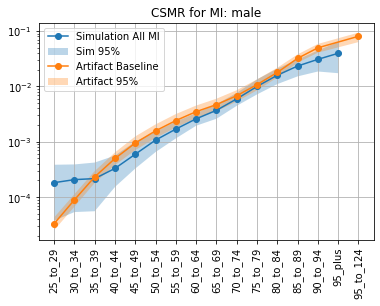

In [72]:
for sex in total_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = total_MI_rate_allyear.loc[(total_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [73]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [74]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000156,0.0,0.000619
1,25_to_29,male,0.000124,0.0,0.000490
2,30_to_34,female,0.000192,0.0,0.000570
3,30_to_34,male,0.000197,0.0,0.000757
4,35_to_39,female,0.000219,0.0,0.000618


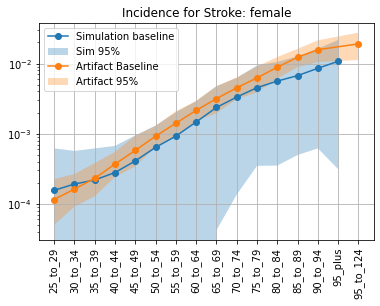

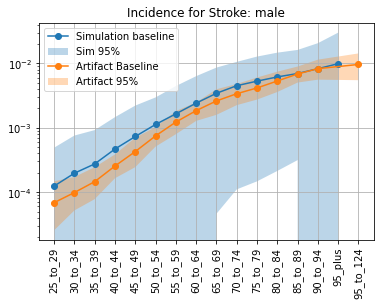

In [75]:
with PdfPages('model1vv_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [76]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000452,0.000284,0.000616,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000510,0.000345,0.000683,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000426,0.000296,0.000581,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000540,0.000414,0.000690,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000850,0.000649,0.001110,Alabama,incidence_rate,45_to_49


In [77]:
tran_rate_sum_allyear = (tran_rate_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000461,0.000188,0.000819
1,25_to_29,male,0.000432,0.000165,0.000735
2,30_to_34,female,0.000511,0.000269,0.000835
3,30_to_34,male,0.000637,0.000275,0.001040
...,...,...,...,...,...
26,90_to_94,female,0.022756,0.016412,0.029711
27,90_to_94,male,0.033237,0.023611,0.044203
28,95_plus,female,0.031320,0.023352,0.043416
29,95_plus,male,0.045351,0.025675,0.069006


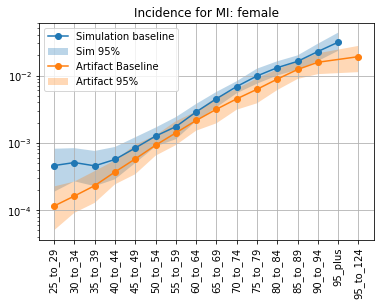

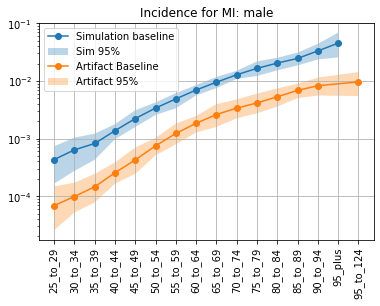

In [78]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence Rates

In [79]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [80]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


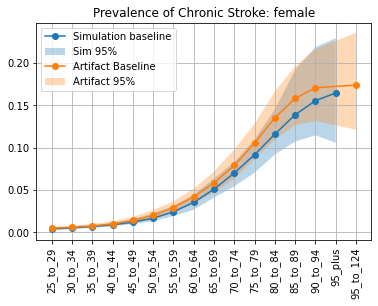

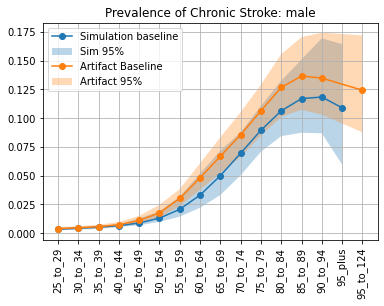

In [81]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [82]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [83]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

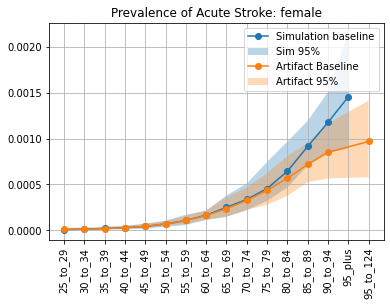

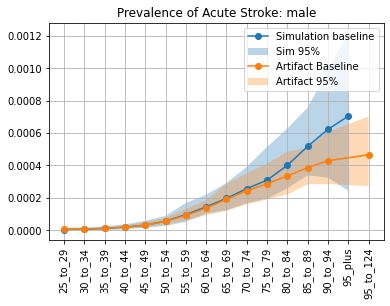

In [84]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [85]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002536,0.001865,0.003277,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004012,0.003125,0.005009,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005660,0.004450,0.007101,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007613,0.005996,0.009425,Alabama,prevalence,45_to_49


In [86]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001543,0.001087,0.002046
1,25_to_29,male,0.001184,0.000735,0.001715
2,30_to_34,female,0.003076,0.002128,0.004073
3,30_to_34,male,0.002699,0.001734,0.003904
4,35_to_39,female,0.004593,0.003269,0.006122


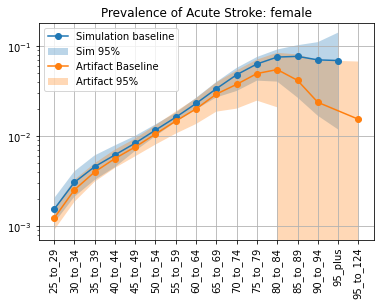

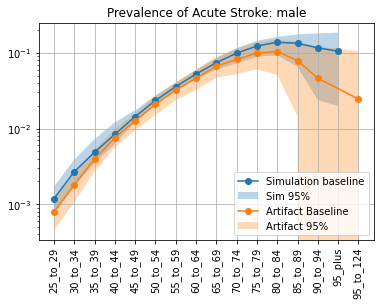

In [87]:
for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Excess Mortality Rate

#### Acute Stroke

In [88]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [89]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.257875,0.0,2.608929
1,25_to_29,male,0.695343,0.0,6.522321
2,30_to_34,female,0.174683,0.0,2.608929
3,30_to_34,male,0.542834,0.0,4.348214
4,35_to_39,female,0.362425,0.0,3.261161


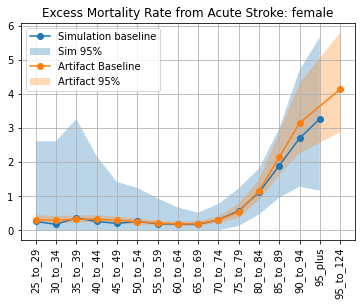

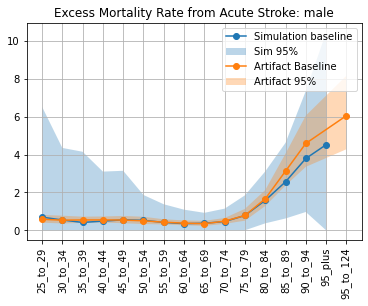

In [90]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [91]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [92]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000000,0.0,0.000000
1,25_to_29,male,0.000000,0.0,0.000000
2,30_to_34,female,0.000031,0.0,0.000000
3,30_to_34,male,0.000100,0.0,0.000000
4,35_to_39,female,0.000141,0.0,0.002329


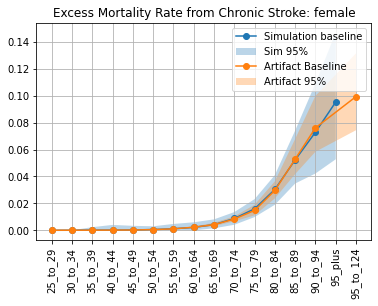

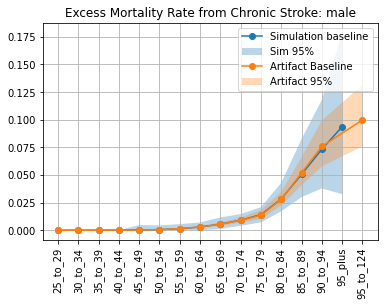

In [93]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [94]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [95]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = pd.concat([acute_MI_emr_rate, acute_MI_EMR.ptvalue], axis=1)
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


acute_MI_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,2.792273,0.0,6.522321
1,25_to_29,male,3.480243,0.0,7.218036
2,30_to_34,female,2.150938,0.0,4.677237
3,30_to_34,male,2.802837,0.0,5.977274
4,35_to_39,female,1.584827,0.0,4.348214


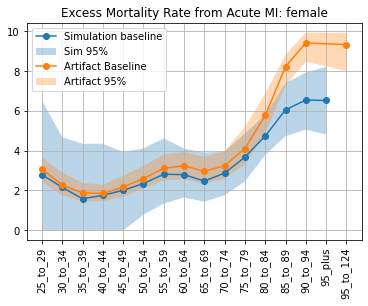

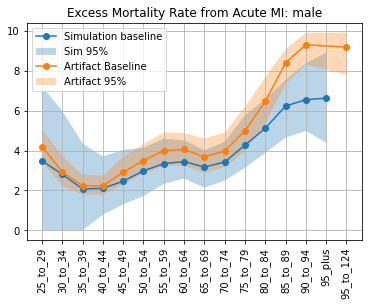

In [96]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [97]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.043965,0.0,0.117669
1,25_to_29,male,0.056285,0.0,0.159928
2,30_to_34,female,0.023560,0.0,0.059734
3,30_to_34,male,0.026675,0.0,0.065147
4,35_to_39,female,0.016071,0.0,0.043963


In [98]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

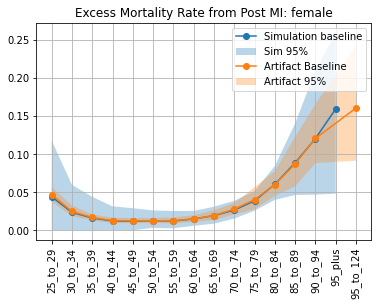

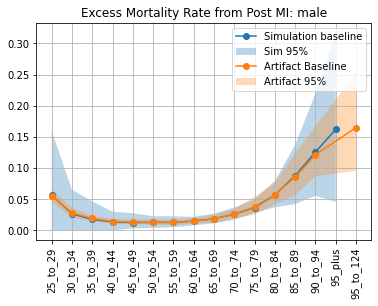

In [99]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### GBD Comparison

#### All Cause Mortality Rate

In [100]:
from db_queries import get_outputs as go

In [101]:
gbd_data = go("cause", gbd_round_id=5, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=523, year_id=2017, sex_id=[1,2])

In [102]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,294,523,1,3,1,2017,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002376,0.002729,0.002043,25_to_29
1,10,294,523,1,3,2,2017,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.001029,0.001216,0.000865,25_to_29
2,11,294,523,1,3,1,2017,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002790,0.003207,0.002396,30_to_34
3,11,294,523,1,3,2,2017,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.001484,0.001756,0.001249,30_to_34
4,12,294,523,1,3,1,2017,_all,35 to 39,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.003384,0.003948,0.002857,35_to_39


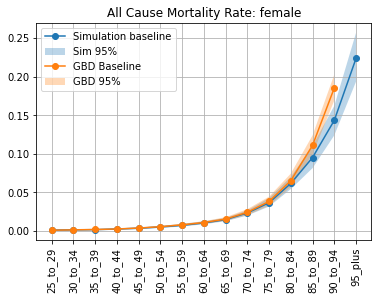

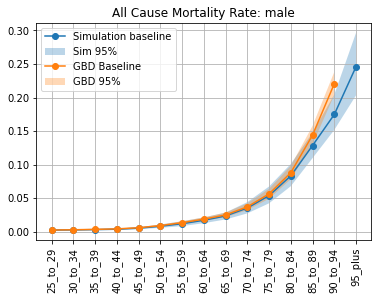

In [103]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate

In [104]:
gbd_incd = go("cause", gbd_round_id=5, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=523, year_id=2017, sex_id=[1,2])

In [105]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,6,3,1,2017,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000063,0.000113,0.000024,25_to_29
1,10,495,523,6,3,2,2017,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000080,0.000134,0.000034,25_to_29
2,11,495,523,6,3,1,2017,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000135,0.000198,0.000083,30_to_34
3,11,495,523,6,3,2,2017,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000145,0.000213,0.000089,30_to_34
4,12,495,523,6,3,1,2017,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000265,0.000397,0.000161,35_to_39


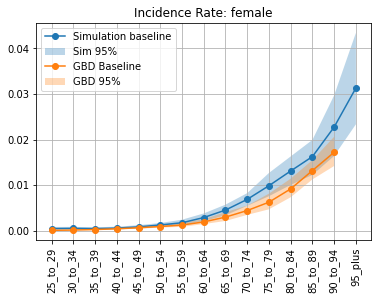

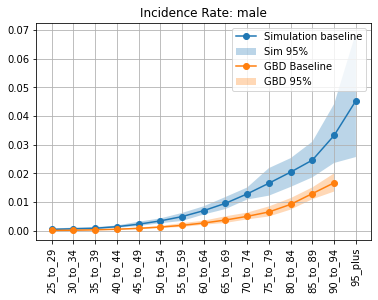

In [106]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### All Cause DALYs

In [107]:
gbd_daly = go("cause", gbd_round_id=5, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=2, metric_id=3, location_id=523, year_id=2017, sex_id=[1,2])

In [108]:
gbd_daly['age'] = gbd_daly.age_group_name.str.replace(' ', '_')
gbd_daly.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,294,523,2,3,1,2017,_all,25 to 29,All causes,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.255686,0.294141,0.221213,25_to_29
1,10,294,523,2,3,2,2017,_all,25 to 29,All causes,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.197619,0.237120,0.161874,25_to_29
2,11,294,523,2,3,1,2017,_all,30 to 34,All causes,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.275488,0.317702,0.237829,30_to_34
3,11,294,523,2,3,2,2017,_all,30 to 34,All causes,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.228573,0.270464,0.188792,30_to_34
4,12,294,523,2,3,1,2017,_all,35 to 39,All causes,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.300765,0.347284,0.258560,35_to_39


In [109]:
daly = daly.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_rate = pd.concat([daly, per_time_group.ptvalue], axis=1)
daly_rate['daly_rate'] = daly_rate['daly'] / daly_rate['ptvalue']
daly_sum_allyear = (daly_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.069411,0.038411,0.099900
1,25_to_29,male,0.025243,0.000000,0.165201
2,30_to_34,female,0.085422,0.055764,0.117076
3,30_to_34,male,0.024480,0.000000,0.166632
4,35_to_39,female,0.092636,0.065531,0.125977


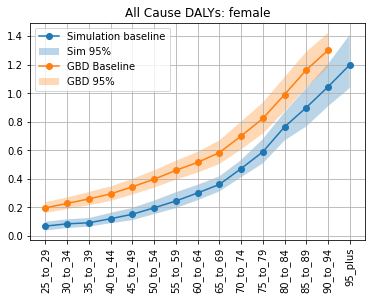

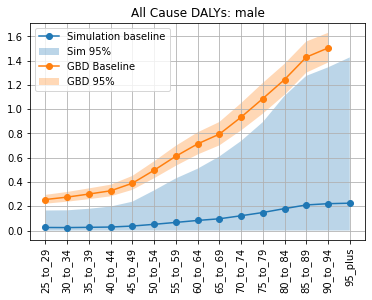

In [110]:
for sex in daly_sum_allyear.sex.unique():
    plt.figure() 
    subdata = daly_sum_allyear.loc[(daly_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly.loc[(gbd_daly.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 